# DDPG Algorithm

## Depandancies

In [1]:
import random
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

## Actor and Critic Network

In [2]:
class Actor(nn.Module):
    def __init__(self, input_dim, first_dim, second_dim, n_actions,action_low,action_high,alpha, device = "cpu"):
        super(Actor, self).__init__()

        self.input_dim = input_dim
        self.first_dim = first_dim
        self.second_dim = second_dim
        self.n_actions = n_actions
        self.alpha = alpha
        self.device = device 

        # Action scaling bounds
        self.action_low = torch.tensor(action_low, dtype=torch.float32).to(device)
        self.action_high = torch.tensor(action_high, dtype=torch.float32).to(device)

        # Define layers
        # First layer processes the state input
        self.first_layer = nn.Linear(self.input_dim, self.first_dim)

        # Second layer processes the intermediate representation
        self.second_layer = nn.Linear(self.first_dim, self.second_dim)

        # Output layer produces actions
        self.output_layer = nn.Linear(self.second_dim, self.n_actions)

        # Initialization
        self.initialize_weights()

    def initialize_weights(self):
        # initialization of weights to zero for first and second layers
        nn.init.xavier_uniform_(self.first_layer.weight)
        nn.init.zeros_(self.first_layer.bias)
        nn.init.xavier_uniform_(self.second_layer.weight)
        nn.init.zeros_(self.second_layer.bias)

        # Output layer initialized to small values initially
        nn.init.uniform_(self.output_layer.weight, -0.003, 0.003)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, state):
        """
        Forward pass of the Actor network.
        Args:
            state: Tensor of state inputs.
        Returns:
            Actions bounded between -1 and 1.
        """
        # Pass state through the first layer and apply ReLU activation
        first_out = F.relu(self.first_layer(state))

        # Pass through the second layer and apply ReLU activation
        second_out = F.relu(self.second_layer(first_out))

        # Output actions with tanh activation to bound between -1 and 1
        action = torch.tanh(self.output_layer(second_out))

        return action

    # Scale actions to ensure compatability with Panda-Gym's environments

    def scale_action(self, action):
        """
        Scale actions from [-1, 1] to [action_low, action_high].
        """
        return self.action_low + (action + 1.0) * 0.5 * (self.action_high - self.action_low)


class Critic(nn.Module):

    def __init__(self, input_dim, first_dim, second_dim, n_actions,alpha, device = "cpu"):
        super(Critic, self).__init__()

        # Define Dimensions
        self.input_dim = input_dim
        self.first_dim = first_dim
        self.second_dim = second_dim
        self.n_actions = n_actions
        self.alpha = alpha
        self.device = device  # Store device

        # Define layers 
        self.first_layer = nn.Linear(self.input_dim,self.first_dim)
        self.second_layer = nn.Linear(self.first_dim + self.n_actions, self.second_dim)
        self.output_layer = nn.Linear(self.second_dim,1)

        # Initialization weights
        self.initialize_weights()

    def initialize_weights(self):
        # initialize weights in every layer
        for layer in [self.first_layer, self.second_layer, self.output_layer]:
            # use xavier_unifrom_ for stable learning
            nn.init.xavier_uniform_(layer.weight)
            # intialize to zeros
            nn.init.zeros_(layer.bias)

    def forward(self,state,action):

        """
        Forward pass of the Critic Network

        Args: 
        State: Tensor of state inputs
        Action: Tensor of actions (continous values)

        Returns:    
            Q-value as a scaler Tensor
        """

        # Pass the state through the first layer and apply ReLU activation
        state_out = F.relu(self.first_layer(state))

        # Concatenate the state features with the action input
        state_action = torch.cat([state_out, action], dim=1)

        # Pass through the second layer and apply ReLU activation
        second_out = F.relu(self.second_layer(state_action))

        # Output the Q-value
        q_value = self.output_layer(second_out)

        return q_value



## Replay Buffer

In [3]:
class ReplayBuffer(object):

    """Replay Bufferclass contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices, as_tensor = False):
        """ Function to fetch the state, action, reward, next state, and done arrays.
        
            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """

        obs_shape = self._data_buffer[0][0].shape
        action_shape = self._data_buffer[0][1].shape

        obs_array = np.zeros((len(indices), *obs_shape), dtype=np.float32)
        action_array = np.zeros((len(indices), *action_shape), dtype=np.float32)
        reward_array = np.zeros(len(indices), dtype=np.float32)
        next_obs_array = np.zeros((len(indices), *obs_shape), dtype=np.float32)
        done_array = np.zeros(len(indices), dtype=np.float32)

        # collect the data
        for i, idx in enumerate(indices):
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the arrays
            obs_array[i] = obs
            action_array[i]= act
            reward_array[i] = reward
            next_obs_array[i] = next_obs
            done_array[i] = d

        if as_tensor:
            return (
                torch.tensor(obs_array, dtype=torch.float32),
                torch.tensor(action_array, dtype=torch.float32),
                torch.tensor(reward_array, dtype=torch.float32),
                torch.tensor(next_obs_array, dtype=torch.float32),
                torch.tensor(done_array, dtype=torch.float32),
            )
        return obs_array, action_array, reward_array, next_obs_array, done_array

    def sample_batch(self, batch_size, as_tensor = False):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        
        # batch-size check
        if batch_size > len(self._data_buffer):
            raise ValueError(f"Batch size ({batch_size}) exceeds buffer size ({len(self._data_buffer)})")
        
        indices = np.random.choice(len(self._data_buffer), size = batch_size, replace = False)
        return self._encode_sample(indices, as_tensor = as_tensor)


## DDPG Agent

In [4]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound, replay_buffer, actor, critic, 
                 actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=0.005, batch_size=64, device='cpu'):
        """
        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            action_bound (float): Maximum absolute value for actions.
            replay_buffer (ReplayBuffer): Replay buffer for experience replay.
            actor (nn.Module): Actor network.
            critic (nn.Module): Critic network.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
            gamma (float): Discount factor.
            tau (float): Soft update factor.
            batch_size (int): Batch size for training.
        """
        self.device = torch.device(device)
        self.state_dim = state_dim
        self.action_dim = action_dim 
        self.action_bound = action_bound

        # Replay buffer
        self.replay_buffer = replay_buffer

        # Actor and Target Actor
        self.actor = actor.to(self.device)
        self.target_actor = type(actor)(
            input_dim=actor.input_dim,
            first_dim=actor.first_dim,
            second_dim=actor.second_dim,
            n_actions=actor.n_actions,
            action_low=actor.action_low,
            action_high=actor.action_high,
            alpha=actor.alpha
        ).to(self.device)

        # Critic and Target Critic
        self.critic = critic.to(self.device)
        self.target_critic = type(critic)(
            input_dim=critic.input_dim,
            first_dim=critic.first_dim,
            second_dim=critic.second_dim,
            n_actions=critic.n_actions,
            alpha=critic.alpha
        ).to(self.device)

        # Action Bounds
        self.action_low = actor.action_low.to(self.device)
        self.action_high = actor.action_high.to(self.device)

        # Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Sync target networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Other Parameters
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

    def soft_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * source_param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, state, noise_scale=0.1, explore=True):
        if isinstance(state, dict):
            state = state["observation"]
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        action = self.actor(state_tensor).detach().cpu().numpy()[0]
        if explore:
            action += noise_scale * np.random.normal(size=self.action_dim)
        action = np.clip(action, self.action_low.cpu().numpy(), self.action_high.cpu().numpy())
        return action

    def update(self):
        """
        Perform one training step for the Actor and Critic networks.
        """
        if len(self.replay_buffer) < self.batch_size:
            return None, None

        # Sample a batch of transitions
        states, actions, rewards, next_states, dones = self.replay_buffer.sample_batch(
            self.batch_size, as_tensor=True
        )

        # Move sampled tensors to the device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Update Critic
        with torch.no_grad():
            target_next_actions = self.target_actor(next_states)
            target_q_values = self.target_critic(next_states, target_next_actions)
            target_q_values = rewards + self.gamma * (1 - dones) * target_q_values.squeeze()

        current_q_values = self.critic(states, actions).squeeze()
        critic_loss = nn.MSELoss()(current_q_values, target_q_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        predicted_actions = self.actor(states)
        actor_loss = -self.critic(states, predicted_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.soft_update(self.target_actor, self.actor)
        self.soft_update(self.target_critic, self.critic)

        return critic_loss.item(), actor_loss.item()



## Environment Selection

In [5]:
" CHANGE BASED ON DESIRED ENVIRONMENT "

#env = gym.make("PandaReach-v3")
#env = gym.make("PandaPush-v3")
#env = gym.make("PandaSlide-v3")
#env = gym.make("PandaPickAndPlace-v3")
#env = gym.make("PandaStack-v3")
#env = gym.make("PandaFlip-v3")

env = gym.make("gym_robot_arm:robot-arm-v0")

ModuleNotFoundError: No module named 'gym_robot_arm'. Environment registration via importing a module failed. Check whether 'gym_robot_arm' contains env registration and can be imported.

## Training Loop

In [ ]:
def train_agent(env, agent, episodes, max_steps):
    rewards_log = []
    timestep_rewards = []
    timestep_losses = []

    timestep = 0
    replay_buffer = agent.replay_buffer

    for episode in range(episodes):
        # Reset environment and prepare initial state
        raw_state, _ = env.reset()
        state = raw_state.get("observation", raw_state)
        if not isinstance(state, np.ndarray):
            state = np.array(state, dtype=np.float32)

        episode_reward = 0

        for step in range(max_steps):
            # Select an action with exploration noise
            action = agent.select_action(state)
            raw_next_state, reward, done, _, info = env.step(action)
            next_state = raw_next_state.get("observation", raw_next_state)
            if not isinstance(next_state, np.ndarray):
                next_state = np.array(next_state, dtype=np.float32)

            # Add the transition to the replay buffer
            replay_buffer.add(state, action, reward, next_state, done)

            # Start training only when replay buffer has enough samples
            if len(replay_buffer) >= agent.batch_size:
                critic_loss, actor_loss = agent.update()
                if critic_loss is not None and actor_loss is not None:
                    timestep_losses.append((timestep, (critic_loss, actor_loss)))

            state = next_state
            episode_reward += reward
            timestep += 1
            timestep_rewards.append((timestep, episode_reward))

            if done:
                break

        rewards_log.append(episode_reward)
        print(f"Episode {episode + 1}/{episodes}, Reward: {episode_reward}")

    return rewards_log, timestep_rewards, timestep_losses


## Experimentation

Starting Trial 1/1


C:\Users\abduf\AppData\Local\Temp\ipykernel_77568\4099265177.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.action_low = torch.tensor(action_low, dtype=torch.float32).to(device)
C:\Users\abduf\AppData\Local\Temp\ipykernel_77568\4099265177.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.action_high = torch.tensor(action_high, dtype=torch.float32).to(device)
Trial 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

Episode 1/100, Reward: -1000.0
Episode 2/100, Reward: -1000.0
Episode 3/100, Reward: -1000.0
Episode 4/100, Reward: -1000.0
Episode 5/100, Reward: -1000.0
Episode 6/100, Reward: -1000.0
Episode 7/100, Reward: -1000.0
Episode 8/100, Reward: -1000.0
Episode 9/100, Reward: -1000.0
Episode 10/100, Reward: -1000.0
Episode 11/100, Reward: -1000.0
Episode 12/100, Reward: -1000.0
Episode 13/100, Reward: -1000.0
Episode 14/100, Reward: -1000.0
Episode 15/100, Reward: -1000.0
Episode 16/100, Reward: -1000.0
Episode 17/100, Reward: -1000.0
Episode 18/100, Reward: -1000.0
Episode 19/100, Reward: -1000.0
Episode 20/100, Reward: -1000.0
Episode 21/100, Reward: -1000.0
Episode 22/100, Reward: -1000.0
Episode 23/100, Reward: -1000.0
Episode 24/100, Reward: -1000.0
Episode 25/100, Reward: -1000.0
Episode 26/100, Reward: -1000.0
Episode 27/100, Reward: -1000.0
Episode 28/100, Reward: -1000.0
Episode 29/100, Reward: -1000.0
Episode 30/100, Reward: -1000.0
Episode 31/100, Reward: -1000.0
Episode 32/100, R

Trial 1/1: 100%|██████████| 100/100 [14:42<00:00,  8.83s/it]

Episode 100/100, Reward: -1000.0


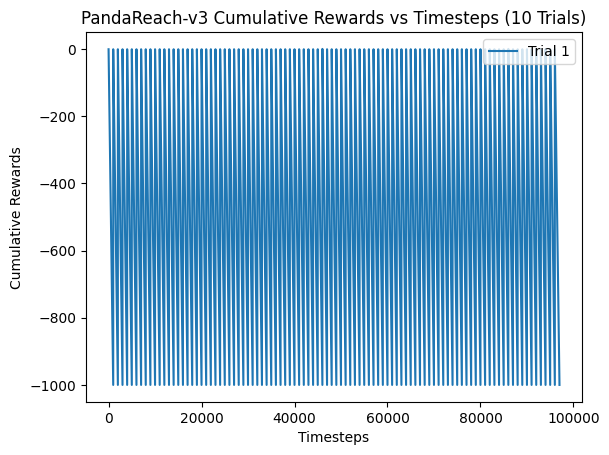

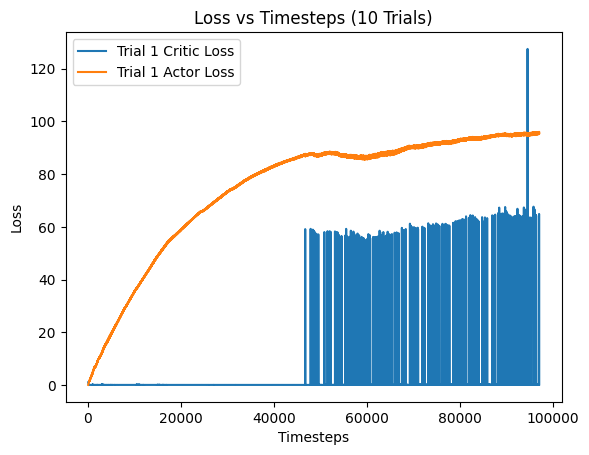

In [ ]:
if __name__ == '__main__':
    # Set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # Environment details
    env_name = "PandaReach-v3"
    num_trials = 1
    episodes_per_trial = 100
    max_steps = 1000

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_train_rewards = []
    all_timestep_rewards = []
    all_timestep_losses = []

    for trial in range(num_trials):
        print(f"Starting Trial {trial + 1}/{num_trials}")

        # Create environment
        env = gym.make(env_name)

        # Get state and action space details
        if isinstance(env.observation_space, gym.spaces.Dict):
            state_dim = env.observation_space["observation"].shape[0]
        else:
            state_dim = env.observation_space.shape[0]

        action_dim = env.action_space.shape[0]
        action_bound = env.action_space.high[0]

        # Replay Buffer set-up
        buffer_size = 100_000
        replay_buffer = ReplayBuffer(buffer_size)

        # Define Actor and Critic Networks
        hidden_dim = 256  # Number of neurons in hidden layers
        actor = Actor(
            input_dim=state_dim, first_dim=hidden_dim, second_dim=hidden_dim,
            n_actions=action_dim, action_low=env.action_space.low,
            action_high=env.action_space.high, alpha=1e-4, device=device
        )
        critic = Critic(
            input_dim=state_dim, first_dim=hidden_dim, second_dim=hidden_dim,
            n_actions=action_dim, alpha=1e-4, device=device
        )

        # Initialize the DDPG Agent
        agent = DDPGAgent(
            state_dim=state_dim,
            action_dim=action_dim,
            action_bound=action_bound,
            replay_buffer=replay_buffer,
            actor=actor,  # Pass the Actor network
            critic=critic,  # Pass the Critic network
            actor_lr=1e-4,
            critic_lr=1e-4,
            gamma=0.99,
            tau=0.005,
            batch_size=128,
            device=device
        )

        # Training loop with progress bar
        trial_train_rewards = []
        trial_timestep_rewards = []
        trial_timestep_losses = []
        with tqdm(total=episodes_per_trial, desc=f"Trial {trial + 1}/{num_trials}") as pbar:
            train_rewards, timestep_rewards, timestep_losses = train_agent(env, agent, episodes=episodes_per_trial, max_steps=max_steps)
            trial_train_rewards.extend(train_rewards)
            trial_timestep_rewards.extend(timestep_rewards)
            trial_timestep_losses.extend(timestep_losses)
            pbar.update(episodes_per_trial)

        all_train_rewards.append(trial_train_rewards)
        all_timestep_rewards.append(trial_timestep_rewards)
        all_timestep_losses.append(trial_timestep_losses)

    # Save results
    np.save("all_train_rewards.npy", all_train_rewards)
    np.save("all_timestep_rewards.npy", all_timestep_rewards)
#    np.save("all_timestep_losses.npy", all_timestep_losses)

    # Aggregate and visualize
    avg_train_rewards = np.mean(all_train_rewards, axis=0)

    # Cumulative rewards vs timesteps
    for trial_idx, trial_rewards in enumerate(all_timestep_rewards):
        timesteps, rewards = zip(*trial_rewards)
        plt.plot(timesteps, rewards, label=f"Trial {trial_idx + 1}")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.title("PandaReach-v3 Cumulative Rewards vs Timesteps")
    plt.legend()
    plt.show()

    # Loss vs timesteps
    for trial_idx, trial_losses in enumerate(all_timestep_losses):
        if trial_losses:
            timesteps, losses = zip(*trial_losses)
            critic_losses, actor_losses = zip(*losses)
            plt.plot(timesteps, critic_losses, label=f"Trial {trial_idx + 1} Critic Loss")
            plt.plot(timesteps, actor_losses, label=f"Trial {trial_idx + 1} Actor Loss")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.title("Loss vs Timesteps")
    plt.legend()
    plt.show()

